# Imports

In [22]:
import time
import os,pickle
import numpy as np
from matplotlib import pyplot as plt
from importlib import reload

from common import numerical_recipes as numrec
from common.baseclasses import AWA
from common.misc import autopickle

from NearFieldOptics import Materials as M

import ProbeCavityEigenfields as PCE
from ProbeCavityEigenfields import RotationalMoM as RotMOM
from ProbeCavityEigenfields import ProbeSpectroscopy as PS
#from ProbeCavityEigenfields import RotationalMoM_new as RotMOMnew

#import numba
#eload(np) 
#reload(numba) 
#print('Numba version:',numba.__version__)
print('Numpy version:',np.__version__) # version 0.6 appears not compatible with numpy 1.22 - 1.24

Numpy version: 1.24.4


# Build probe

In [68]:
a_nm=20
a=a_nm*1e-7 #in cm
L=24e-4 #probe length in cm, assuming cantilever thickness 4e-4 #Arrow probe: https://www.nanoworld.com/tapping-mode-reflex-coated-afm-tip-arrow-ncr
L_microns=L*1e4
taper_angle=21 # Arrow probe: https://www.researchgate.net/figure/SEM-image-of-an-AFM-tip-attached-to-cantilever_fig6_224406883
geometry='hyperboloid'
PCE.Probe.dtype = np.complex64

WL_THz=300e-4 #300 microns wavelength
freq_THz=1/WL_THz
freq=30*freq_THz # 30 THz

Nsubnodes=2
Nnodes=244

probe_name = '%s_a=%inm_taper=%i_L=%imicrons_Nnodes=%i'%(geometry.capitalize(),a_nm,taper_angle,L_microns,Nnodes)
#probe_name = 'MidIRHyperboloid_FreqDepNormalization_L=%imicrons'%(L*1e4,)
print('Building probe %s...'%probe_name)

Building probe Hyperboloid_a=20nm_taper=21_L=23microns_Nnodes=244...


<ProbeCavityEigenfields._ProbesCollection.__setitem__>:
	Registering probe "Hyperboloid_a=20nm_taper=21_L=23microns_Nnodes=244"...
<ProbeCavityEigenfields.Probe.__init__>:
	Generating probe "Hyperboloid_a=20nm_taper=21_L=23microns_Nnodes=244"...
<ProbeCavityEigenfields.RotationalMoM.get_BoR_radii>:
	Getting geometry for selection "hyperboloid"...
<ProbeCavityEigenfields.RotationalMoM.BodyOfRevolution.__init__>:
	Re-meshing provided geometry to quadrature points along annular coordinate `t`...
<ProbeCavityEigenfields.RotationalMoM.BodyOfRevolution.__init__>:
	Discretizing body of revolution over 382 annular nodes and 2 subnodes...
<ProbeCavityEigenfields.RotationalMoM.ImpedanceMatrix>:
	Preparing quasistatic mirror impedance matrix at k=0...
	Progress: 99.74%	Total quadrature time: 5.68s, time per quadrature evaluation: 3.89E-05s
<ProbeCavityEigenfields.RotationalMoM.ImpedanceMatrix>:
	Preparing dynamic self impedance matrix at k=6.3E+03...
	Progress: 99.74%	Total quadrature time: 15.48

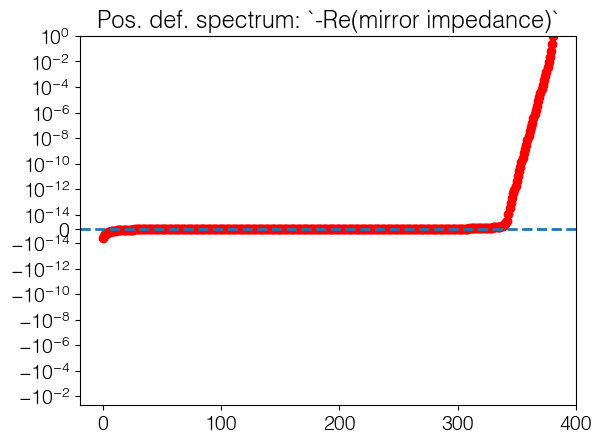

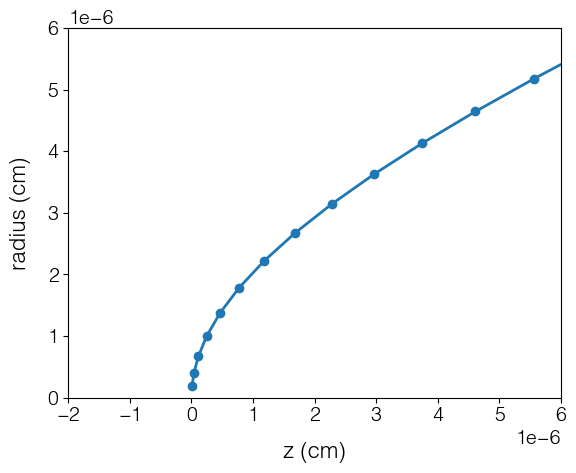

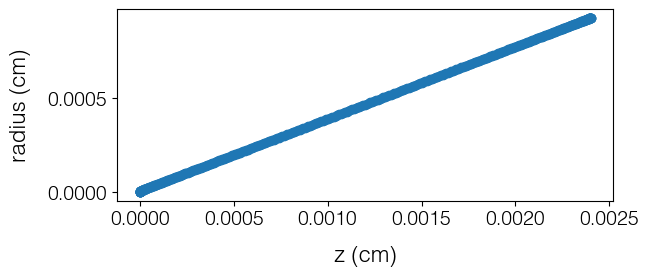

In [69]:
# Load the probe or build the probe
recompute = True
overwrite = True
try:
    if recompute: raise ValueError
    P = PCE.load(probe_name,PCE.Probe)
except (FileNotFoundError,ValueError): 

    P=PCE.Probe(Nnodes=Nnodes,Nsubnodes=Nsubnodes,L=L,quadrature=numrec.TS,\
                     a=a,taper_angle=taper_angle,geometry=geometry,
                freq=freq,gap=a,name=probe_name)

    RotMOM.quadlimit = int(1e4)
    #Zmirror = P.get_mirror_impedance(k=0,kappa_min=.1/L,recompute=False,sommerfeld=True,Nkappas=244*8)
    Zmirror = P.get_mirror_impedance(sommerfeld=False)
    #Zself = P.get_self_impedance(k=P.get_k(),recompute=True)
    rhos,Js = P.solve_eigenmodes(condition_ZM=True,condition_ZS=False,ZMthresh=0,recompute_impedance=False)
    
    try: PCE.save(P,overwrite=overwrite)
    except OSError: pass
    
ztip=P.get_gap()
zs=P.get_zs()
Rs=P.get_radii()
k=P.get_k()
    
plt.figure()
Rs.plot(marker='o')
plt.gca().set_aspect('equal')
plt.xlim(-a,3*a)
plt.ylim(0,3*a)
plt.ylabel('radius (cm)')
plt.xlabel('z (cm)')

plt.figure()
Rs.plot(marker='o')
plt.gca().set_aspect('equal')
plt.ylabel('radius (cm)')
plt.xlabel('z (cm)')

RotMOM.quadlimit = int(1e4)
#Zmirror = P.get_mirror_impedance(k=P.get_k(),nonsingular=False,recompute=True)
#Zmirror = P.get_mirror_impedance(k=0,nonsingular=False,recompute=True)
#Zmirror = P.get_mirror_impedance(k=P.get_k(),farfield=False,recompute=True,sommerfeld=True,Nkappas=244*8,rp=rp_au,\
#                                kappa_min=P.get_k()*.01)

(0.0, 15.0)

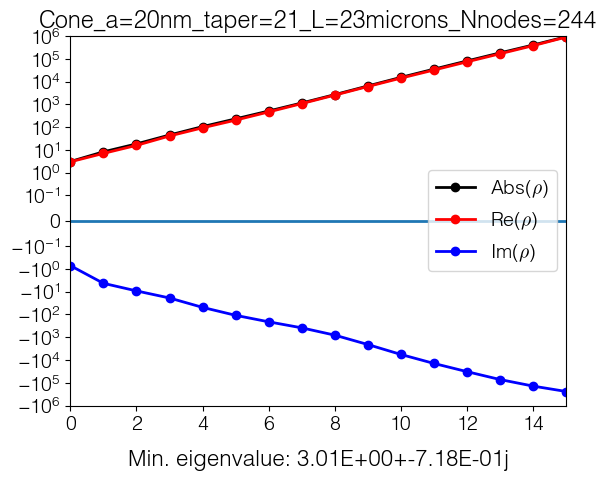

In [60]:
P.plot_eigenrhos()
plt.xlim(0,15)

# Probe Gap Spectroscopy

In [70]:
gaps = np.logspace(-1.5, 1.5, 100) * P.get_a() # in cgs units, like everything else here
#gaps = np.linspace(.1,10,100)*a
reload(PS)

recompute=True
overwrite=True
#kwargs=dict(sommerfeld=True, kappa_max = None, Nkappas = 244*4 ) # adaptive kappa_max
kwargs=dict(sommerfeld=False,basis_gap = P.get_a())

try:
    if recompute: raise ValueError
    ProbeGapSpectroscopy = PCE.load(P, PS.ProbeGapSpectroscopyParallel, overwrite_probe=True)
    
except (FileNotFoundError,ValueError):
    ProbeGapSpectroscopy = PS.ProbeGapSpectroscopyParallel(Probe=P, gaps=gaps,
                                                        ncpus=8, backend='loky',
                                                        Nmodes=50, reversed=False,**kwargs)
    try: PCE.save(ProbeGapSpectroscopy,overwrite=overwrite)
    except OSError: pass

We are computing an eigenset at gap=2E-06, and using its first 50 modes as a basis for forthcoming calculations!
Starting gap=2e-06
<ProbeCavityEigenfields.RotationalMoM.ImpedanceMatrix>:
	Preparing quasistatic mirror impedance matrix at k=0...
	Progress: 99.74%	Total quadrature time: 5.44s, time per quadrature evaluation: 3.73E-05s
<ProbeCavityEigenfields.Probe.reset_eigenproperties>:
	Resetting eigenproperties...
Finished gap=2e-06, elapsed time: 5.7 s
Basis will have length 50


python(73138) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(73139) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(73140) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(73141) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(73142) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(73143) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(73144) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(73145) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


<plotting>:
	Registered colormaps "Warm" and "Warm_r"...
<plotting>:
	Registered colormaps "vanheum" and "vanheum_r"...
<plotting>:
	Registered colormaps "NT-MDT" and "NT-MDT_r"...
<plotting>:
<plotting>:
	Registered colormaps "jingdi" and "jingdi_r"...
<plotting>:
	Registered colormaps "Halcyon" and "Halcyon_r"...
<plotting>:
	Registered colormaps "Cold" and "Cold_r"...
<plotting>:
	Registered colormaps "Sky" and "Sky_r"...
<plotting>:
	Registered colormaps "Gwyddion.net" and "Gwyddion.net_r"...
<plotting>:
	Registered colormaps "BlueRed" and "BlueRed_r"...
<plotting>:
	Registered colormaps "vanheum3" and "vanheum3_r"...
<plotting>:
	Registered colormaps "vanheum2" and "vanheum2_r"...
<__init__._ProbesCollection.__setitem__>:
	Registering probe "Hyperboloid_a=20nm_taper=21_L=23microns_Nnodes=244"...
Starting gap=7.8e-08
<__init__.Probe.reset_eigenproperties>:
	Resetting eigenproperties...
<RotationalMoM.ImpedanceMatrix>:
	Preparing quasistatic mirror impedance matrix at k=0...
	Progre

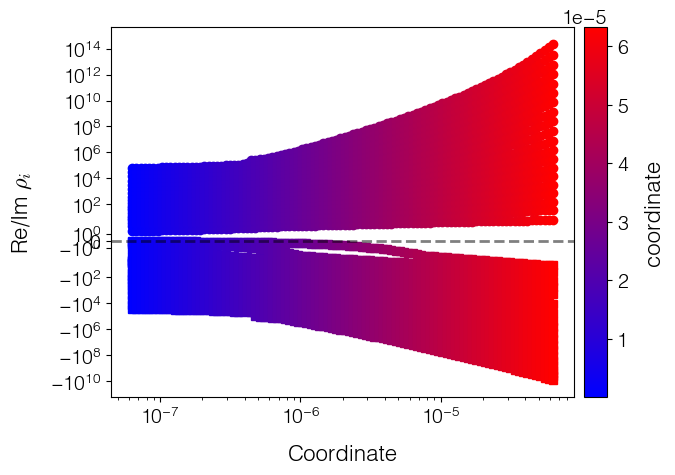

In [71]:
ProbeGapSpectroscopy.plot_eigenrhos_scatter(Nmodes=20,versus_coord=True)
plt.gcf().axes[0].set_xscale('log')

Text(0.5, 0, 'Gap size')

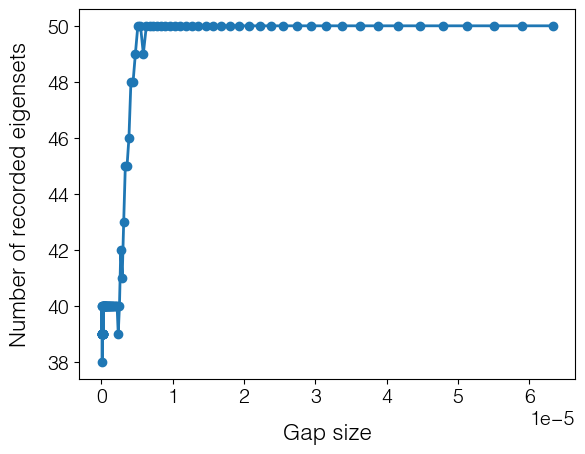

In [72]:
gaps = ProbeGapSpectroscopy._recorded_eigenrhos.keys()
Ns = [len(ProbeGapSpectroscopy._recorded_eigenrhos[gap]) for gap in gaps]
plt.plot(gaps,Ns,marker='o')
plt.ylabel('Number of recorded eigensets')
plt.xlabel('Gap size')

## Classify and plot dispersion of eignmodes with gap

In [73]:
Nmodes=50
# Start from the highest reliable coordinate to make sure we don't miss the lowest order modes
ProbeGapSpectroscopy(Nmodes=Nmodes,reversed=True,by_rho=True,debug=False,coordmax=None)
eigenrhos = ProbeGapSpectroscopy.get_eigenrhos_AWA(Nmodes=Nmodes)
eigencharges = ProbeGapSpectroscopy.get_eigencharges_AWA()

Classifying eigensets by eigenindex, with reversal...
Looking for Nmodes=38 (maximum uniformly available in coordinate range).
	Progress: 99.00%<ProbeCavityEigenfields.ProbeSpectroscopy.ProbeGapSpectroscopyParallel.align_eigencharge_signs>:
	Aligning signage of 38 eigenmode charges over 100 coordinates...


Text(0.5, 0, 'Gap/a')

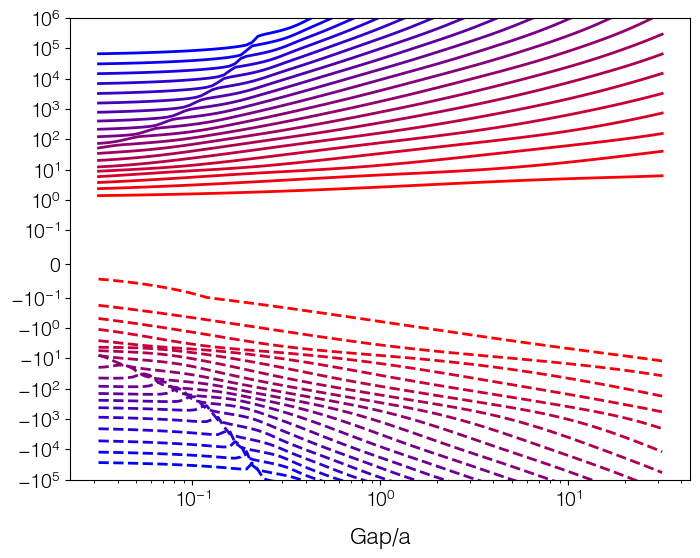

In [74]:
Nmodes_plot=20
colors=zip(np.linspace(1,0,Nmodes_plot),[0]*Nmodes_plot,np.linspace(0,1,Nmodes_plot))
plt.figure(figsize=(8,6))

a=P.get_a()
gaps=eigenrhos.axes[1]
for n in range(Nmodes_plot):
    c=next(colors)
    rhos=eigenrhos[n]
    plt.plot(gaps/a,rhos.real,marker='',color=c)
    plt.plot(gaps/a,rhos.imag,marker='',color=c,ls='--')
    
plt.gca().set_yscale('symlog',linthresh=.1)
plt.ylim(-1e5,1e6)
#plt.xlim(.0074,.0076)
#plt.xlim(np.min(freqs),.002)
plt.gca().set_xscale('log')
plt.xlabel('Gap/a')

## Compute brightness associated to eigenmodes

<ProbeCavityEigenfields.ProbeSpectroscopy.ProbeGapSpectroscopyParallel.get_eigenbrightness_AWA>:
	Computing brightnesses across 100 spectroscopy coordinates...


Text(0.5, 1.0, 'Brightness')

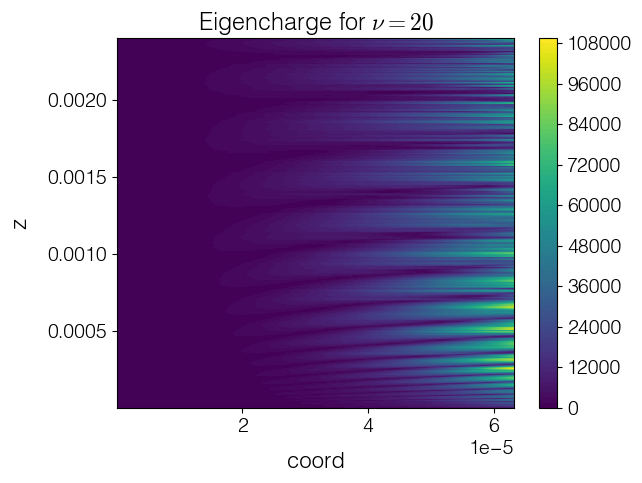

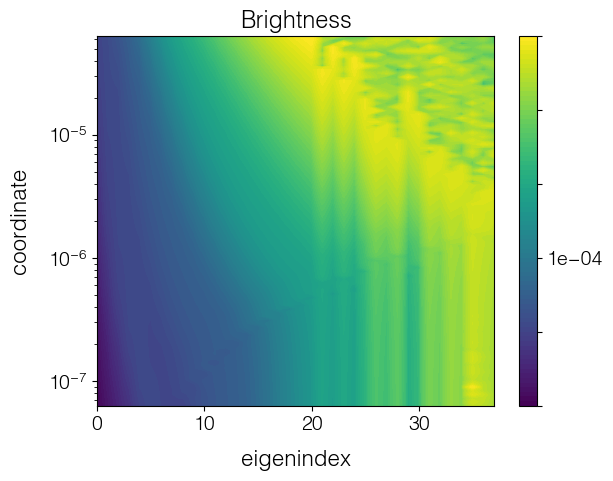

In [75]:
eigenind=20
np.abs(ProbeGapSpectroscopy._eigencharges_AWA[eigenind].real).plot(plotter=plt.contourf)
plt.title(r'Eigencharge for $\nu=%i$'%eigenind)

angles=np.linspace(10,90,20)
all_vs = ProbeGapSpectroscopy.get_eigenbrightness_AWA(recompute=False,
                                                        angles=angles,
                                                        verbose=True)
plt.figure()
np.abs(all_vs).plot(plotter=plt.contourf,log_scale=True)
plt.gca().set_yscale('log')
plt.title('Brightness')

## Save after having computed properties of eigencharges

In [76]:
overwrite=True
save=True

if save:
    try: PCE.save(ProbeGapSpectroscopy,overwrite=overwrite)
    except OSError: pass # didn't want to overwrite

Successfully saved to file "/Users/alexandersmcleod/tools/python/ProbeCavityEigenfields/Probe models/(Hyperboloid_a=20nm_taper=21_L=23microns_Nnodes=244)_ProbeGapSpectroscopy.pickle"!


# Build Encoded Eigenfields from gap spectroscopy

In [77]:
gap0 = P.get_a()
Nmodes=15
EE = PS.EncodedEigenfields(ProbeGapSpectroscopy,gap0=gap0, Nmodes=Nmodes,
                            kappa_min=None, kappa_max=20/a,
                            Nkappas=244*8, qquadrature=PCE.numrec.GL)

<ProbeCavityEigenfields.ProbeSpectroscopy.EncodedEigenfields.__init__>:
	Encoding 15 eigenfields to gap=2e-06 across 100 gap values from gap=(6.3e-08 to 6.3e-05)...
<ProbeCavityEigenfields.ProbeSpectroscopy.ProbeGapSpectroscopyParallel.get_probe_at_coord>:
	Updating eigenrhos to coordinate 1.93E-06...
	Updating eigencharges...
	Updating self impedance...
	Updating mirror impedance...
<ProbeCavityEigenfields.Probe.getFourPotentialPropagators>:
	Computing field propagators at k=0...
	Including evanescent (near-field) waves..


In [78]:
overwrite=True
save=True

if save:
    try: PCE.save(EE,overwrite=overwrite)
    except OSError: pass # didn't want to overwrite

Successfully saved to file "/Users/alexandersmcleod/tools/python/ProbeCavityEigenfields/Probe models/(Hyperboloid_a=20nm_taper=21_L=23microns_Nnodes=244)_EncodedEigenfields.pickle"!
	Total quadrature time: 7.96s, time per quadrature evaluation: 5.46E-05s
Basis has length 50
Finished gap=3.9e-05, elapsed time: 8.1 s
	Total quadrature time: 7.99s, time per quadrature evaluation: 5.48E-05s
Basis has length 50
Finished gap=2.9e-05, elapsed time: 8.1 s
	Total quadrature time: 8.01s, time per quadrature evaluation: 5.49E-05s
Basis has length 50
Finished gap=3.4e-05, elapsed time: 8.1 s
	Total quadrature time: 8.03s, time per quadrature evaluation: 5.50E-05s
Basis has length 50
Finished gap=4.2e-05, elapsed time: 8.2 s
	Total quadrature time: 4.78s, time per quadrature evaluation: 3.28E-05s
Basis has length 50
Finished gap=6.3e-05, elapsed time: 4.9 s
	Total quadrature time: 4.78s, time per quadrature evaluation: 3.28E-05s
Basis has length 50
Finished gap=5.1e-05, elapsed time: 4.9 s
	Total q

# Probe Frequency Spectroscopy

## Load or build spectroscopy

In [ ]:
freqs=np.linspace(0.5,80,200)*freq_THz
reload(PS)

recompute=False

try:
    if recompute: raise ValueError
    ProbeFreqSpectroscopy = PCE.load(P, PS.ProbeFrequencySpectroscopyParallel, overwrite_probe=True)
    
except (FileNotFoundError,ValueError):
    ProbeFreqSpectroscopy = PS.ProbeFrequencySpectroscopyParallel(Probe=P, freqs=freqs,
                                                                 ncpus=8, backend='loky',
                                                                 Nmodes=20, reversed=False)
    PCE.save(ProbeFreqSpectroscopy,overwrite=True)

In [ ]:
ProbeFreqSpectroscopy.plot_eigenrhos_scatter(Nmodes=10,versus_coord=True)
plt.gcf().axes[0].set_xscale('linear')

## Classify and plot dispersion of probe poles

In [ ]:
ProbeFreqSpectroscopy(Nmodes=20,reverse=False,by_rho=True,debug=False)
eigenrhos = ProbeFreqSpectroscopy.get_eigenrhos_AWA(Nmodes=20)
eigencharges = ProbeFreqSpectroscopy.get_eigencharges_AWA(Nmodes=20)

In [ ]:
np.abs(eigencharges[0]).plot() # higher order eigencharges show some weird sharp defects (eigenvalue error?), but oh well

In [ ]:
N=14
colors=zip(np.linspace(1,0,N),[0]*N,np.linspace(0,1,N))
plt.figure(figsize=(8,6))

freqs=eigenrhos.axes[1]
for n in range(N):
    c=next(colors)

    if n==0:
        label1=r'Re($\rho$)'
        label2=r'Im($\rho$)'
    else: label1=label2=None
        
    rhos=eigenrhos[n]
    plt.plot(freqs/freq_THz,rhos.real,marker='',color=c,label=label1)
    plt.plot(freqs/freq_THz,rhos.imag,marker='',color=c,label=label2)
    
plt.gca().set_yscale('symlog',linthresh=.1)
plt.ylim(-1e7,1e8)
#plt.xlim(.0074,.0076)
#plt.xlim(np.min(freqs),.002)
plt.xlabel('Frequency (THz)')
plt.ylabel(r'$\rho$',fontsize=20)
plt.legend(frameon=True)

#--- Plot some antenna mode frequencies

f=.8
plt.axvline(f/(2*L)/freq_THz,color='k',ls='--') #This is where probe ~ lambda/2 antenna - radiative Q?
plt.axvline(f/L/freq_THz,color='k',ls='--') #This is where probe ~ lambda antenna - radiative Q?
plt.axvline(f*3/(2*L)/freq_THz,color='k',ls='--')
plt.axvline(f*2/(L)/freq_THz,color='k',ls='--')

plt.axhline(0,ls=':',color='k',alpha=.4)
plt.title(ProbeFreqSpectroscopy.get_probe().get_name())